In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import time
import vtk
from utils import *
from numba import jit
from scipy.spatial.distance import cdist

sns.set_style('white')
sns.set(font_scale=2)

In [3]:
# Specify parameters
l = 2 # Edge length of domain
N_U = 1000 # Number of points in population U (randomly distributed across domain)
N_V = 200 # Number of points in population V ('fixed' points equally spaced along middle of domain)

# wPCF parameters
maxR = l*0.5 # Maximum radial value to plot wPCF to
radius_step = 0.01*l # Resolution in radius to plot wPCF
dr = 0.01*l # Width of the annulus considered for wPCF

# Calculate helpers
midpoint = l*0.5 # Used for placing points in population U
PCF_radii_lower = np.arange(0, maxR, radius_step)
PCF_radii_upper = PCF_radii_lower + dr

In [4]:
# Create population U - N_U points distributed via complete spatial randomness
points_U = l*np.random.rand(N_U,2)
labels_U = np.abs(midpoint - points_U[:,1])/midpoint

# Create population V - N_V points across domain centre
#points_V = np.asarray([(v,midpoint) for v in np.linspace(1,l-1,N_V)])*1.0
points_V = np.asarray([(l*v/N_V,midpoint) for v in np.linspace(1,N_V,N_V)])

cmap_U = plt.cm.viridis_r
# plt.figure(figsize=(12,9))
# plt.scatter(points_V[:,0],points_V[:,1],marker='x',color=[1,0,1])
# plt.scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
# plt.gca().axis('square')
# plt.xlim([0,l])
# plt.ylim([0,l])
# plt.colorbar()

In [5]:
# Define various weighting functions
# Throughout the paper, we use 'linear_med'
weightFunctions = ['uniform','linear','squares','linear_med','linear_narrow','squares_narrow']
def getWeights(p,phenotypes,weightFunction):
    if weightFunction == 'uniform':
        weights = np.ones(np.shape(phenotypes))
    if weightFunction == 'linear':
        weights = 1-np.abs(p-phenotypes)
    if weightFunction == 'squares':
        weights = 1-(p-phenotypes)**2
    if weightFunction == 'linear_narrow':
        weights = 1-10*np.abs(p-phenotypes)
    if weightFunction == 'linear_med':
        weights = 1-5*np.abs(p-phenotypes)
    if weightFunction == 'squares_narrow':
        weights = 1-100*(p-phenotypes)**2
    weights = np.maximum(weights, np.zeros(np.shape(weights)))
    return weights

def calculateCombinationWeights(weights_i, weights_j, combinationWeightFunction):
    weights_matrix = np.tile(weights_i, (len(weights_j), 1)).transpose()
#     print(np.shape(weights_matrix))
    if combinationWeightFunction == 'multiply':
        combinationWeights = weights_matrix * weights_j
    combinationWeights = np.maximum(combinationWeights, np.zeros(np.shape(combinationWeights)))
    return combinationWeights
weightToUse = 'linear_med'

In [6]:
# Calculate the wPCF

# Calculate distances to nearby cells, keeping each contribution associated with the label of that point
distances = cdist(points_V, points_U, metric='euclidean')
areas = getAnnulusAreasAroundPoints(points_V, radius_step, maxR, l)
# wPCF
# Constant population: points_V
# Varying population: points_U (by labels_U)

dP = 0.01
uRange = np.arange(0,1+dP,dP);

wPCFstore = np.ones(shape=(len(PCF_radii_lower),len(uRange)))
for ind, phi_U in enumerate(uRange):
    weights_U = getWeights(phi_U, labels_U, weightToUse)

    totalWeight_U = sum(weights_U) # W_U
    meanWeight_U = np.mean(weights_U) # W_U / N_U
    density_U = N_U / (l*l) # N_U / A

    wPCF = np.zeros(shape=(len(PCF_radii_lower)))
 
    for annulus in range(len(PCF_radii_lower)):
        inner = PCF_radii_lower[annulus]
        outer = PCF_radii_upper[annulus]

        # Find pairwise distances within this radius
        distanceMask = np.logical_and((distances >= inner),(distances < outer))
        for i in range(N_V):
            # For each blood vessel
            # Find pairwise distances within this radius of bv i
            fillIndices = np.where(distanceMask[i,:])[0]
            m_i = sum(weights_U[fillIndices]) # m_i
            wPCF[annulus] = wPCF[annulus] + m_i*N_U/(totalWeight_U*density_U*areas[i,annulus])

    wPCFstore[:,ind] = wPCF / N_V

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


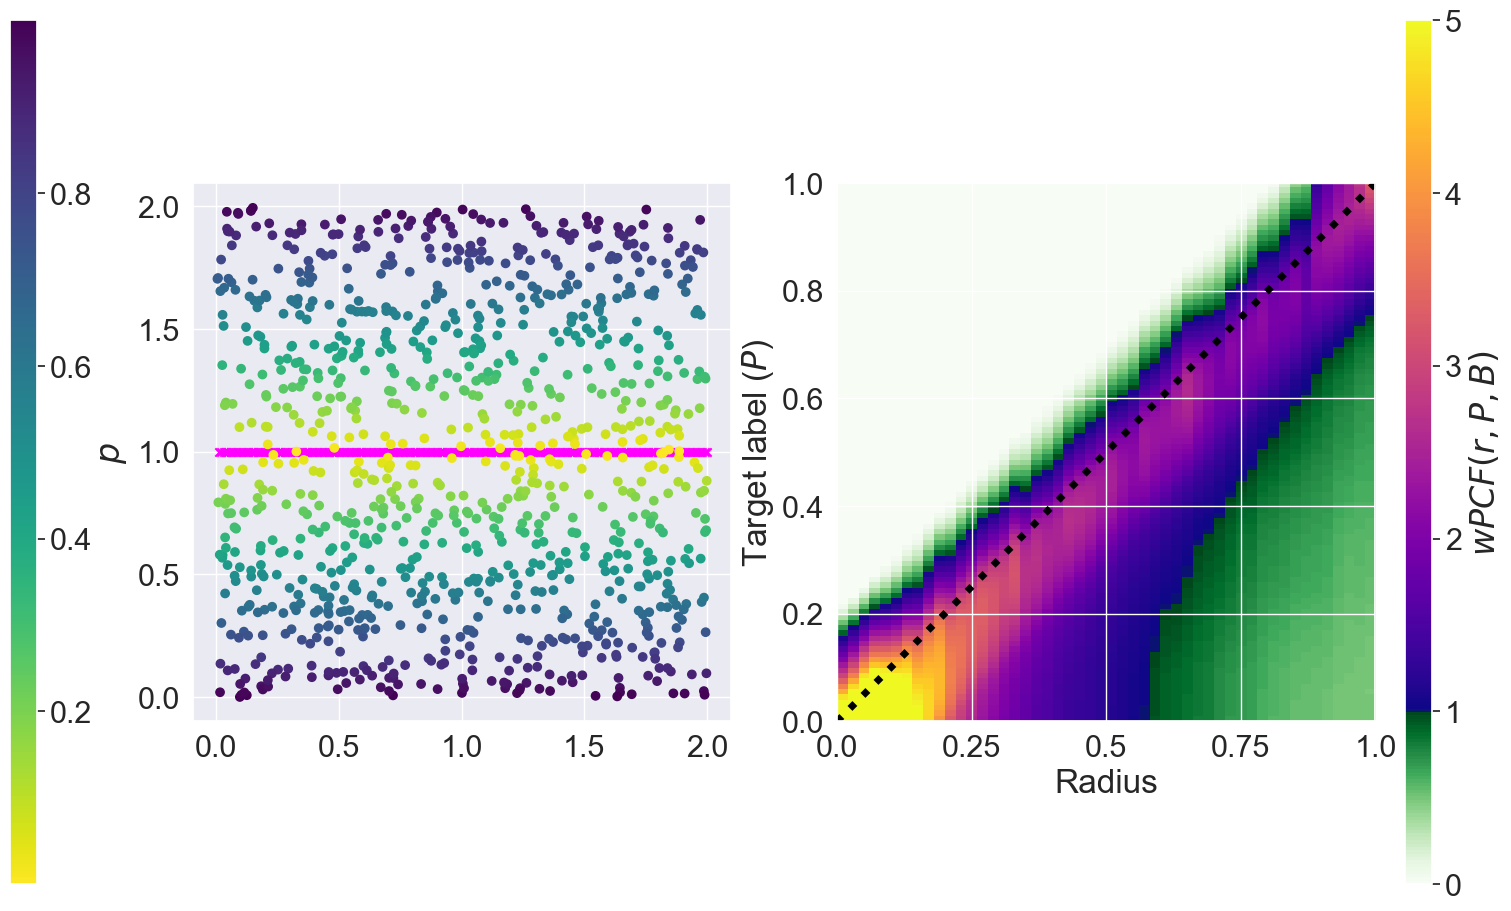

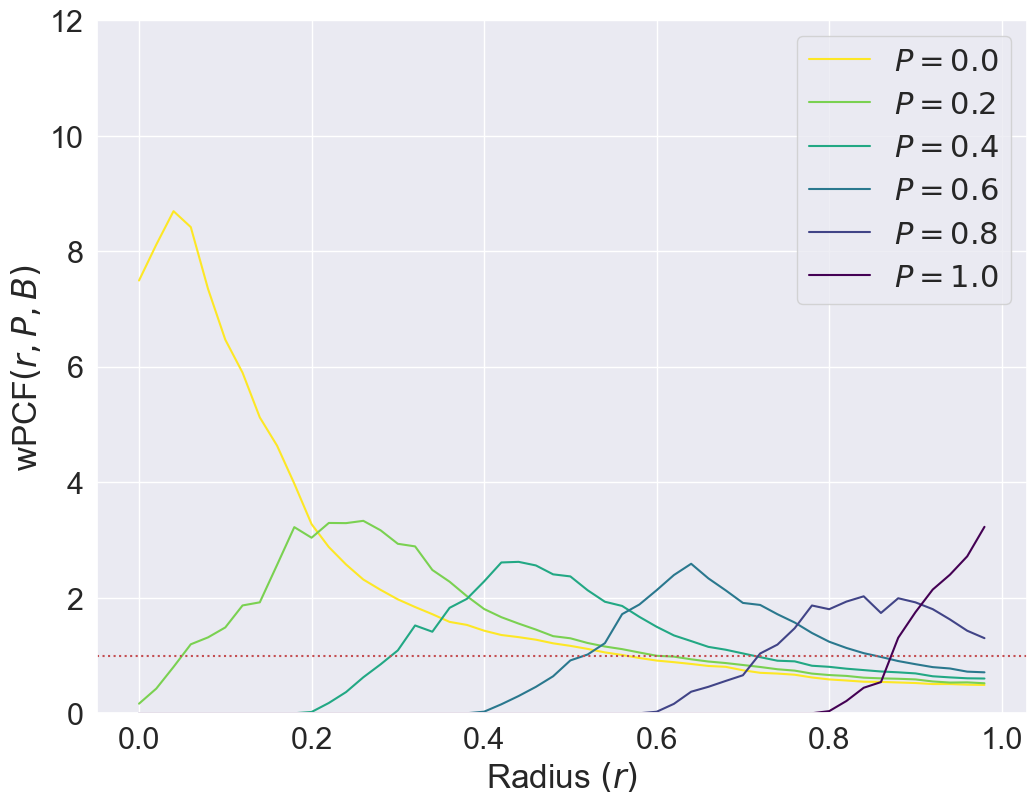

In [9]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(15,9),constrained_layout=True,gridspec_kw={'width_ratios': [0.25, 5, 5, 0.25]})
axes[1].scatter(points_V[:,0],points_V[:,1],marker='x',color=[1,0,1])
axes[1].scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
axes[1].axis('square')

vmin = 0
vmax = 5
one = 1/vmax

# Construct colormap
nCols = 1000
threshold = one*nCols
colors1 = plt.cm.Greens(np.linspace(0, 1, round(threshold)))
colors2 = plt.cm.plasma(np.linspace(0, 1, nCols - round(threshold)))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

axes[2].imshow(wPCFstore.transpose(),origin='lower',extent=[0,1,0,1],cmap=cmap,vmin=vmin,vmax=vmax)
axes[2].set_xlabel('Radius')
tickProps = [0,0.25,0.5,0.75,1]
axes[2].set_xticks(tickProps)
axes[2].set_xticklabels([v*(PCF_radii_lower[-1]+dr) for v in tickProps])
axes[2].set_ylabel('Target label ($P$)')
#axes[2].set_title('wPCF: x_i to y_j (by label)')
axes[2].plot(uRange,uRange,color=[0,0,0],linestyle=':',lw=5)

plt.figure()
plt.scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
plt.gca().axis('square')
plt.colorbar(cax=axes[0],label='$p$')
plt.close()

plt.figure()
plt.imshow(wPCFstore,cmap=cmap,vmin=0,vmax=vmax)
plt.colorbar(cax=axes[3],label='$wPCF(r,P,B)$')
plt.close()

plt.savefig('./wPCFexample.pdf')

plt.figure(figsize=(12,9))
cm = mpl.cm.get_cmap(cmap_U)

for ind, j in enumerate(uRange):
    if ind % round(0.2*len(uRange)) == 0:
        plt.plot(PCF_radii_lower,wPCFstore[:,ind],c=cm(j),label='$P = '+str(j)+'$')
plt.xlabel('Radius $(r)$')
plt.ylabel('wPCF$(r,P,B)$')
plt.ylim([0,12])
plt.gca().axhline(1,c='r',linestyle=':')
plt.legend()
plt.savefig('./wPCFexample_crossSections.pdf')

In [10]:
# Another example
# Create population U - N_U points distributed via complete spatial randomness
points_U = l*np.random.rand(N_U,2)
labels_U = np.abs(midpoint - points_U[:,1])**2/midpoint

# Create population V - N_V points across domain centre
#points_V = np.asarray([(v,midpoint) for v in np.linspace(1,l-1,N_V)])*1.0
points_V = np.asarray([(l*v/N_V,midpoint) for v in np.linspace(1,N_V,N_V)])

cmap_U = plt.cm.viridis_r
# plt.figure(figsize=(12,9))
# plt.scatter(points_V[:,0],points_V[:,1],marker='x',color=[1,0,1])
# plt.scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
# plt.gca().axis('square')
# plt.xlim([0,l])
# plt.ylim([0,l])
# plt.colorbar()

In [11]:
# Calculate the wPCF

# Calculate distances to nearby cells, keeping each contribution associated with the label of that point
distances = cdist(points_V, points_U, metric='euclidean')
areas = getAnnulusAreasAroundPoints(points_V, radius_step, maxR, l)
# wPCF
# Constant population: points_V
# Varying population: points_U (by labels_U)

maxLabel = np.ceil(np.max(np.abs(labels_U)))
dP = maxLabel/100
uRange = np.arange(0,maxLabel+dP,dP);

wPCFstore = np.ones(shape=(len(PCF_radii_lower),len(uRange)))
for ind, phi_U in enumerate(uRange):
    weights_U = getWeights(phi_U, labels_U, weightToUse)

    totalWeight_U = sum(weights_U) # W_U
    meanWeight_U = np.mean(weights_U) # W_U / N_U
    density_U = N_U / (l*l) # N_U / A

    wPCF = np.zeros(shape=(len(PCF_radii_lower)))
 
    for annulus in range(len(PCF_radii_lower)):
        inner = PCF_radii_lower[annulus]
        outer = PCF_radii_upper[annulus]

        # Find pairwise distances within this radius
        distanceMask = np.logical_and((distances >= inner),(distances < outer))
        for i in range(N_V):
            # For each blood vessel
            # Find pairwise distances within this radius of bv i
            fillIndices = np.where(distanceMask[i,:])[0]
            m_i = sum(weights_U[fillIndices]) # m_i
            wPCF[annulus] = wPCF[annulus] + m_i*N_U/(totalWeight_U*density_U*areas[i,annulus])

    wPCFstore[:,ind] = wPCF / N_V

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


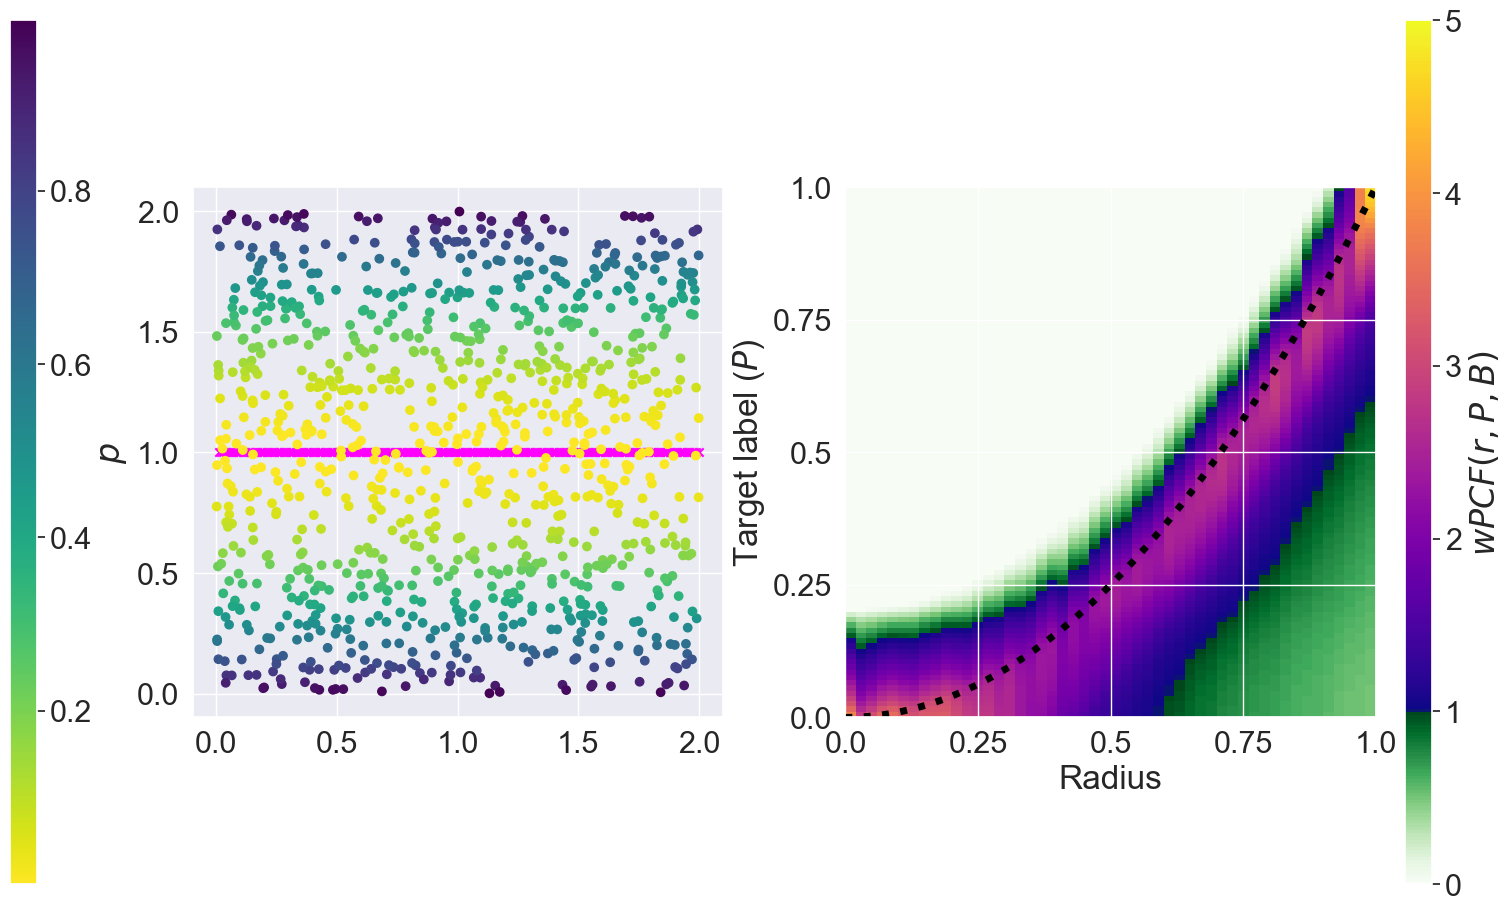

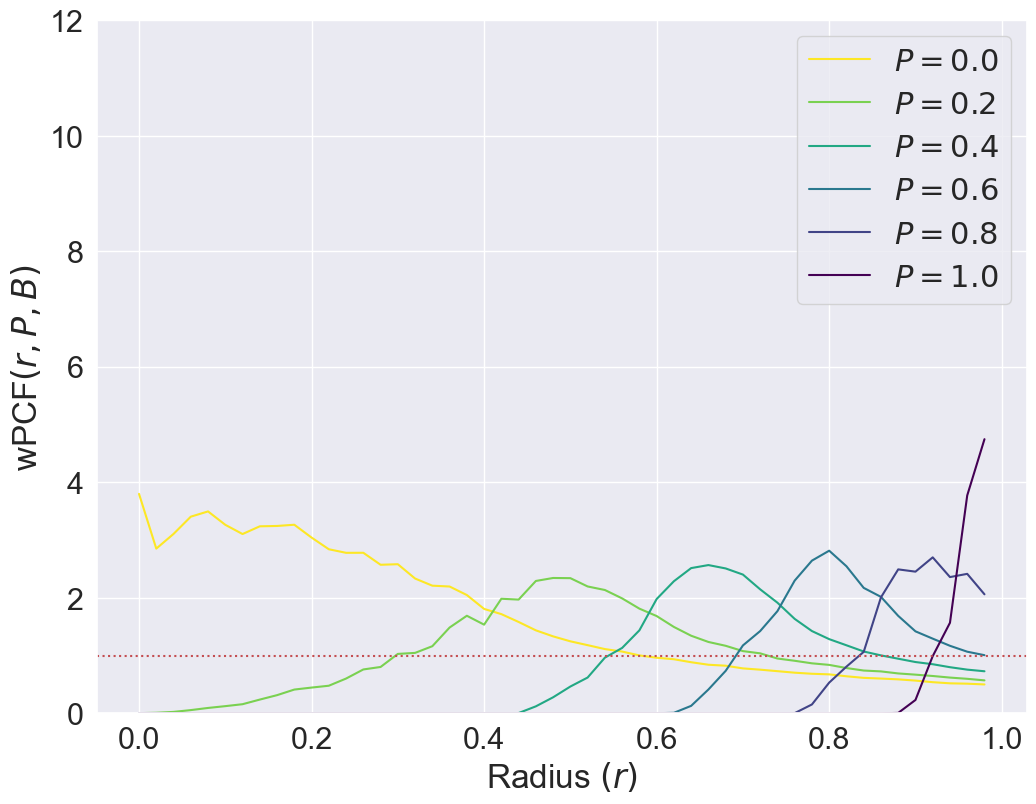

In [13]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(15,9),constrained_layout=True,gridspec_kw={'width_ratios': [0.25, 5, 5, 0.25]})
axes[1].scatter(points_V[:,0],points_V[:,1],marker='x',color=[1,0,1])
axes[1].scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
axes[1].axis('square')

vmin = 0
vmax = 5
one = 1/vmax

# Construct colormap
nCols = 1000
threshold = one*nCols
colors1 = plt.cm.Greens(np.linspace(0, 1, round(threshold)))
colors2 = plt.cm.plasma(np.linspace(0, 1, nCols - round(threshold)))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

axes[2].imshow(wPCFstore.transpose(),origin='lower',extent=[0,1,0,1],cmap=cmap,vmin=vmin,vmax=vmax)
axes[2].set_xlabel('Radius')
tickProps = [0,0.25,0.5,0.75,1]
axes[2].set_xticks(tickProps)
axes[2].set_xticklabels([v*(PCF_radii_lower[-1]+dr) for v in tickProps])
tickProps = [0,0.25,0.5,0.75,1]
axes[2].set_yticks(tickProps)
axes[2].set_yticklabels([v*maxLabel for v in tickProps])
axes[2].set_ylabel('Target label ($P$)')
#axes[2].set_title('wPCF: x_i to y_j (by label)')
axes[2].plot(uRange/uRange[-1],(uRange/uRange[-1])**2,color=[0,0,0],linestyle=':',lw=5)

plt.figure()
plt.scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
plt.gca().axis('square')
plt.colorbar(cax=axes[0],label='$p$')
plt.close()

plt.figure()
plt.imshow(wPCFstore,cmap=cmap,vmin=0,vmax=vmax)
plt.colorbar(cax=axes[3],label='$wPCF(r,P,B)$')
plt.close()

plt.savefig('./wPCFexample_squared.pdf')

plt.figure(figsize=(12,9))
cm = mpl.cm.get_cmap(cmap_U)

for ind, j in enumerate(uRange):
    if ind % round(0.2*len(uRange)) == 0:
        plt.plot(PCF_radii_lower,wPCFstore[:,ind],c=cm(j/maxLabel),label='$P = '+str(j)+'$')
plt.xlabel('Radius $(r)$')
plt.ylabel('wPCF$(r,P,B)$')
plt.ylim([0,12])
plt.gca().axhline(1,c='r',linestyle=':')
plt.legend()
plt.savefig('./wPCFexample_crossSections_squared.pdf')

C:\Users\User\AppData\Local\Temp/ipykernel_17700/2850959167.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


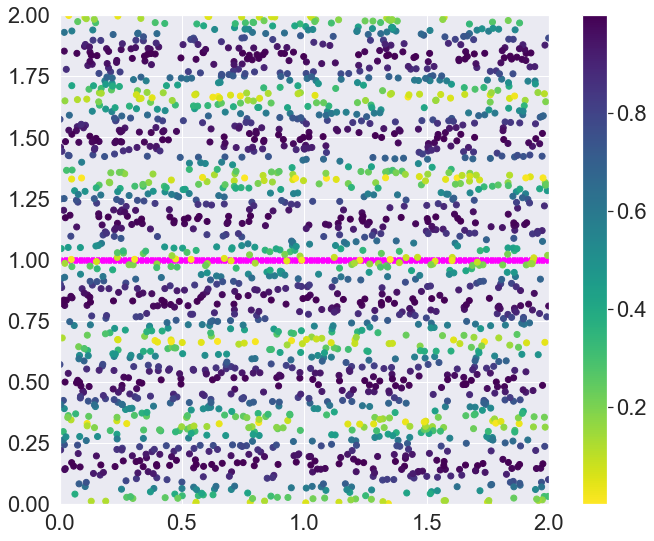

In [10]:
# Yet another example
# Create population U - N_U points distributed via complete spatial randomness
N_U = 2000
points_U = l*np.random.rand(N_U,2)
labels_U = np.abs(np.sin(3*np.pi*np.abs(midpoint - points_U[:,1])/midpoint))

# Create population V - N_V points across domain centre
points_V = np.asarray([(l*v/N_V,midpoint) for v in np.linspace(1,N_V,N_V)])

cmap_U = plt.cm.viridis_r
plt.figure(figsize=(12,9))
plt.scatter(points_V[:,0],points_V[:,1],marker='x',color=[1,0,1])
plt.scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
plt.gca().axis('square')
plt.xlim([0,l])
plt.ylim([0,l])
plt.colorbar()

In [11]:
# Calculate the wPCF

# Calculate distances to nearby cells, keeping each contribution associated with the label of that point
distances = cdist(points_V, points_U, metric='euclidean')
areas = getAnnulusAreasAroundPoints(points_V, radius_step, maxR, l)
# wPCF
# Constant population: points_V
# Varying population: points_U (by labels_U)

maxLabel = 1#np.max(np.abs(labels_U))
dP = maxLabel/100
uRange = np.arange(0,maxLabel+dP,dP);

wPCFstore = np.ones(shape=(len(PCF_radii_lower),len(uRange)))
for ind, phi_U in enumerate(uRange):
    weights_U = getWeights(phi_U, labels_U, weightToUse)

    totalWeight_U = sum(weights_U) # W_U
    meanWeight_U = np.mean(weights_U) # W_U / N_U
    density_U = N_U / (l*l) # N_U / A

    wPCF = np.zeros(shape=(len(PCF_radii_lower)))
 
    for annulus in range(len(PCF_radii_lower)):
        inner = PCF_radii_lower[annulus]
        outer = PCF_radii_upper[annulus]

        # Find pairwise distances within this radius
        distanceMask = np.logical_and((distances >= inner),(distances < outer))
        for i in range(N_V):
            # For each blood vessel
            # Find pairwise distances within this radius of bv i
            fillIndices = np.where(distanceMask[i,:])[0]
            m_i = sum(weights_U[fillIndices]) # m_i
            wPCF[annulus] = wPCF[annulus] + m_i*N_U/(totalWeight_U*density_U*areas[i,annulus])

    wPCFstore[:,ind] = wPCF / N_V

C:\Users\User\AppData\Local\Temp/ipykernel_17700/1263964046.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cax=axes[0])
C:\Users\User\AppData\Local\Temp/ipykernel_17700/1263964046.py:41: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(cax=axes[3])


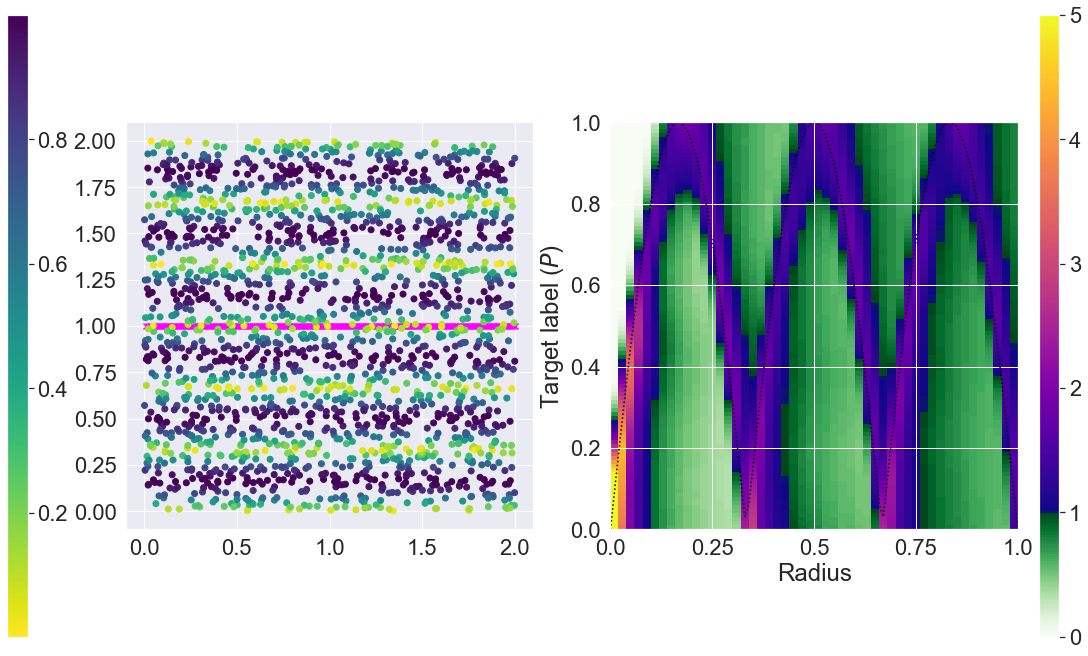

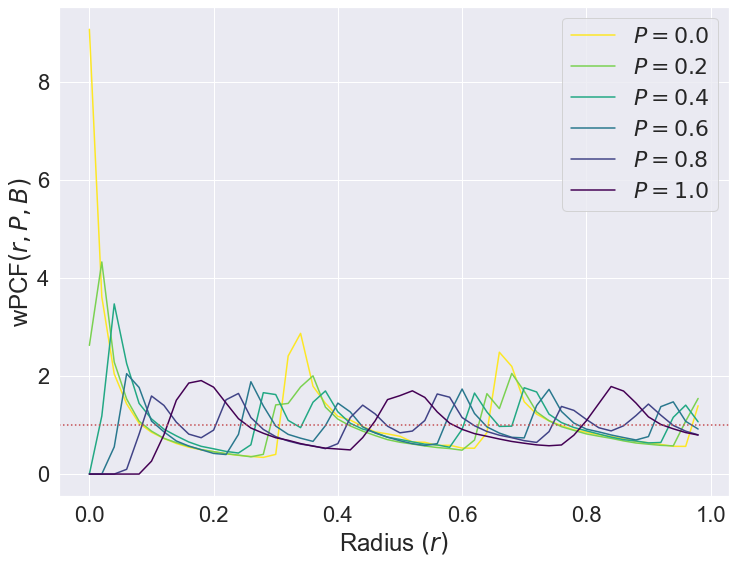

In [12]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(15,9),constrained_layout=True,gridspec_kw={'width_ratios': [0.25, 5, 5, 0.25]})
axes[1].scatter(points_V[:,0],points_V[:,1],marker='x',color=[1,0,1])
axes[1].scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
axes[1].axis('square')

vmin = 0
vmax = 5
one = 1/vmax

# Construct colormap
nCols = 1000
threshold = one*nCols
colors1 = plt.cm.Greens(np.linspace(0, 1, round(threshold)))
colors2 = plt.cm.plasma(np.linspace(0, 1, nCols - round(threshold)))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

axes[2].imshow(wPCFstore.transpose(),origin='lower',extent=[0,1,0,1],cmap=cmap,vmin=vmin,vmax=vmax)
axes[2].set_xlabel('Radius')
tickProps = [0,0.25,0.5,0.75,1]
axes[2].set_xticks(tickProps)
axes[2].set_xticklabels([v*(PCF_radii_lower[-1]+dr) for v in tickProps])
axes[2].set_ylabel('Target label ($P$)')
#axes[2].set_title('wPCF: x_i to y_j (by label)')
axes[2].plot(uRange/uRange[-1],np.abs(np.sin(3*np.pi*(uRange/uRange[-1]))),color=[0,0,0],linestyle=':')
#labels_U = np.sin(3*np.pi*np.abs(midpoint - points_U[:,1])/midpoint)

plt.figure()
plt.scatter(points_U[:,0],points_U[:,1],c=labels_U,cmap=cmap_U)
plt.gca().axis('square')
plt.colorbar(cax=axes[0])
plt.close()

plt.figure()
plt.imshow(wPCFstore,cmap=cmap,vmin=0,vmax=vmax)
plt.colorbar(cax=axes[3])
plt.close()

# plt.savefig('./wPCFexample.eps')

plt.figure(figsize=(12,9))
cm = mpl.cm.get_cmap(cmap_U)

for ind, j in enumerate(uRange):
    if ind % round(0.2*len(uRange)) == 0:
        plt.plot(PCF_radii_lower,wPCFstore[:,ind],c=cm(j),label='$P = '+str(j)+'$')
plt.xlabel('Radius $(r)$')
plt.ylabel('wPCF$(r,P,B)$')
plt.gca().axhline(1,c='r',linestyle=':')
plt.legend()
# plt.savefig('./wPCFexample_crossSections.eps')

In [13]:
ADD NOISE!!!
assert(1==2)

SyntaxError: invalid syntax (Temp/ipykernel_17700/710197810.py, line 1)

In [ ]:
# Second example
l = 50
midpoint = l*0.5
maxR = 25
cmap = plt.cm.viridis_r

N_Y = 500

dr = 1 # dr = width of the annulus
radius_step = 1 # step in the radius
PCF_radii_lower = np.arange(0, maxR, radius_step)
PCF_radii_upper = PCF_radii_lower + dr

col = cmap(0)

points_X = np.asarray([(v,midpoint) for v in range(1,l)])*1.0
points_Y = l*np.random.rand(N_Y,2)
labels_Y = (midpoint - points_Y[:,1])/midpoint
labels_Y[labels_Y < 0] = labels_Y[labels_Y < 0] + 1

plt.figure(figsize=(12,9))
plt.scatter(points_X[:,0],points_X[:,1])
plt.scatter(points_Y[:,0],points_Y[:,1],c=labels_Y,cmap=cmap)
plt.gca().axis('square')
plt.xlim([0,l])
plt.ylim([0,l])
plt.colorbar()

In [ ]:
from scipy.spatial.distance import cdist

N_X = len(points_X)
print(N_X)
# N_Y specified earlier

# Calculate distances to nearby cells, keeping each contribution associated with the phenotype of that point
distances = cdist(points_X, points_Y, metric='euclidean')
areas = getAnnulusAreasAroundPoints(points_X, radius_step, maxR, l)

In [ ]:
# wPCF
# Constant population: points_X
# Varying population: points_Y (by labels_Y)

dP = 0.01
yRange = np.arange(0,1+dP,dP);

wPCFstore = np.ones(shape=(len(PCF_radii_lower),len(yRange)))
for ind, phi_Y in enumerate(yRange):
    weights_Y = getWeights(phi_Y, labels_Y, weightToUse)

    totalWeight_Y = sum(weights_Y) # W_Y
    meanWeight_Y = np.mean(weights_Y) # W_Y / N_Y
    density_Y = N_Y / (l*l) # N_Y / A

    wPCF = np.zeros(shape=(len(PCF_radii_lower)))
 
    for annulus in range(len(PCF_radii_lower)):
        inner = PCF_radii_lower[annulus]
        outer = PCF_radii_upper[annulus]

        # Find pairwise distances within this radius
        distanceMask = np.logical_and((distances >= inner),(distances < outer))
        for i in range(N_X):
            # For each blood vessel
            # Find pairwise distances within this radius of bv i
            fillIndices = np.where(distanceMask[i,:])[0]
            m_i = sum(weights_Y[fillIndices]) # m_i
            wPCF[annulus] = wPCF[annulus] + m_i*N_Y/(totalWeight_Y*density_Y*areas[i,annulus])

    wPCFstore[:,ind] = wPCF / N_X

In [ ]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(15,9),constrained_layout=True,gridspec_kw={'width_ratios': [0.25, 5, 5, 0.25]})
axes[1].scatter(points_X[:,0],points_X[:,1],marker='x')
axes[1].scatter(points_Y[:,0],points_Y[:,1],c=labels_Y,cmap='viridis_r')
axes[1].axis('square')

equalColormap = True
# vmax = np.max(wPCFstore)
vmin = 0
vmax = 5
one = 1/vmax
print(one)
if equalColormap:
    # sample the colormaps that you want to use. Use 128 from each so we get 256
    # colors in total
    nCols = 1000
    threshold = one*nCols
    print(threshold)
    colors1 = plt.cm.Greens(np.linspace(0.2, 1, round(threshold)))
    colors2 = plt.cm.plasma(np.linspace(0, 1, nCols - round(threshold)))

    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    
    axes[2].imshow(wPCFstore,origin='lower',extent=[0,1,0,1],cmap=cmap,vmin=vmin,vmax=vmax)
else:
    cmap = 'inferno'
    axes[2].imshow(wPCFstore,origin='lower',extent=[0,1,0,1],cmap=cmap,vmin=0,vmax=vmax)
    
axes[2].set_ylabel('Radius')
tickProps = [0,0.25,0.5,0.75,1]
axes[2].set_yticks(tickProps)
axes[2].set_yticklabels([v*(PCF_radii_lower[-1]+1) for v in tickProps])
axes[2].set_xlabel('$\\phi_Y$')
# axes[2].set_title('wPCF: x_i to y_j (by label)')

plt.figure()
plt.scatter(points_Y[:,0],points_Y[:,1],c=labels_Y,cmap='viridis_r')
plt.gca().axis('square')
plt.colorbar(cax=axes[0])
plt.close()

plt.figure()
if equalColormap:
    plt.imshow(wPCFstore,cmap=cmap,vmin=0,vmax=vmax)
else:
    plt.imshow(wPCFstore,cmap=cmap,vmin=0,vmax=vmax)
plt.colorbar(cax=axes[3])
plt.close()

plt.figure(figsize=(12,9))
cm = mpl.cm.get_cmap('viridis_r')

for ind, j in enumerate(yRange):
    if ind % round(0.2*len(yRange)) == 0:
        plt.plot(PCF_radii_lower,wPCFstore[:,ind],c=cm(j),label='Label = '+str(j))
plt.xlabel('Radius $(r)$')
plt.ylabel('wPCF$(r)$')
plt.gca().axhline(1,c='r',linestyle=':')
plt.legend()